In [181]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lag
import piml_library.hamiltonian as ham
import piml_library.util as util
import harmonic_ocillation_1D.dataset_generator as dg
import piml_library.plotting as plotting
from piml_library.hnn import (
    HamiltonianNN, 
    compute_loss, 
    train_step, 
    create_trajectory,
    create_trajectory_for_lnn
)

In [182]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lag.coordinate(state)
    v = lag.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [183]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [184]:
# --- ハイパーパラメータ ---
q_dim = 1      
hidden_dim = 200
learning_rate = 1e-2
num_epochs = 4500
key = jax.random.PRNGKey(8)

# --- setup trajectory of training and test data ---
num_trajectories = 100  # 学習用の軌道数
N_points_per_traj = 30      # 1軌道あたりの点の数
t_end = 3.0             # 1軌道のシミュレーション時間
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)

# 学習用とテスト用の時間分割 (50%を学習用)
split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)


--- 学習用・テスト用データセットの生成開始 ---
Generating 100 trajectories...
--- データセット生成完了 ---
Total Train Points: 1500
Total Test Points:  1500


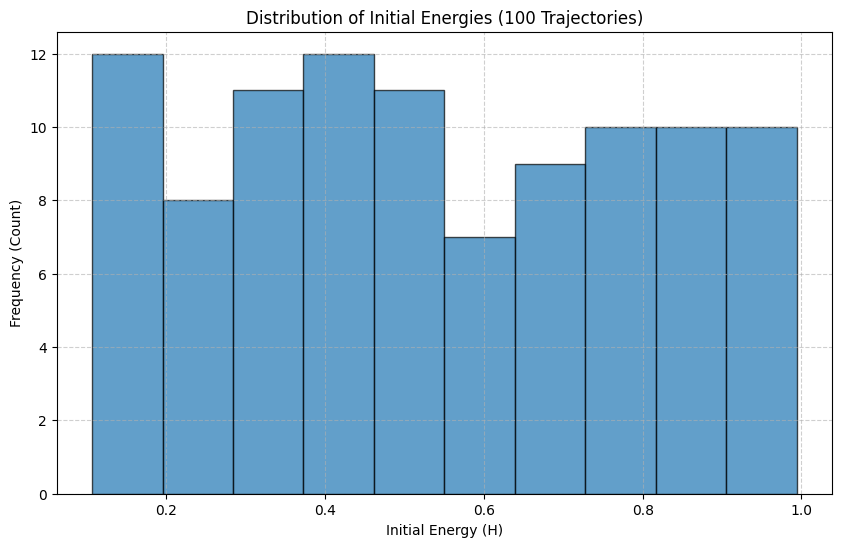

In [185]:
# --- モジュールの関数を呼び出してデータを生成 ---
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states_hnn"]
train_t, train_q, train_p = train_states
train_targets = data_dict["train_targets_hnn"]
train_q_dot_true, train_p_dot_true = train_targets

test_dataset_states = data_dict["test_dataset_states_hnn"]
test_t, test_q, test_p = test_dataset_states
test_dataset_true_derivatives = data_dict["test_dataset_targets_hnn"]


initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [186]:
'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
hnn_model = HamiltonianNN(hidden_dim=hidden_dim, out_dim=q_dim)
model_apply_fn = hnn_model.apply  
true_derivatives = ham.state_derivative(H_analytical)
vmap_true_derivatives = jax.vmap(
    lambda t, q, p: true_derivatives((t, q, p)),
    in_axes=(0,0,0)
)

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_p = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_p)

params = hnn_model.init(init_key, dummy_state)['params'] #構造を決定
optimizer = optax.adamw(learning_rate, weight_decay=1e-5)
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリ状態

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

# ミニバッチのサイズ
batch_size = 256 

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    batch_states = (train_t[indices], train_q[indices], train_p[indices])
    batch_true_derivatives = (train_q_dot_true[indices], train_p_dot_true[indices])
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        train_states, 
        train_targets
    )
    
    if epoch % 500 == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_true_derivatives
        )
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("学習完了。")

# Final Test Loss
final_test_loss = compute_loss(params, model_apply_fn, test_dataset_states, test_dataset_true_derivatives)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 0.290741, Test Loss: 3.857736
Epoch 500, Train Loss: 0.000024, Test Loss: 0.000036
Epoch 1000, Train Loss: 0.000003, Test Loss: 0.000007
Epoch 1500, Train Loss: 0.000002, Test Loss: 0.000004
Epoch 2000, Train Loss: 0.000002, Test Loss: 0.000004
Epoch 2500, Train Loss: 0.000001, Test Loss: 0.000003
Epoch 3000, Train Loss: 0.000001, Test Loss: 0.000002
Epoch 3500, Train Loss: 0.000172, Test Loss: 0.000160
Epoch 4000, Train Loss: 0.000102, Test Loss: 0.000106
学習完了。
--- Final Test Loss: 0.000001 ---
--- Total Training Time: 79.57 seconds ---


In [191]:
'''
generate trajectory
'''
HNN_fn = lambda s: model_apply_fn({'params': params}, s) 
LNN_from_HNN_fn = ham.hamiltonian_to_lagrangian(HNN_fn)

lag_to_ham_state_fn_true = ham.lagrangian_state_to_hamiltonian_state(L_analytical)
ham_to_lag_state_fn_true = ham.hamiltonian_state_to_lagrangian_state(H_analytical)
lag_to_ham_state_fn_learned = ham.lagrangian_state_to_hamiltonian_state(LNN_from_HNN_fn)
ham_to_lag_state_fn_learned = ham.hamiltonian_state_to_lagrangian_state(HNN_fn)

solver_learned_hnn = create_trajectory(model_apply_fn, params)
solver_learned_lnn_from_hnn = create_trajectory_for_lnn(LNN_from_HNN_fn)

# Initial state (t=0, q=1.0, p=0.0)
initial_state_ham = (0.0, jnp.array([1.0]), jnp.array([0.0]))
initial_state_lag = (0.0, jnp.array([1.0]), jnp.array([0.0]))
t_eval = jnp.linspace(0.0, 100.0, 10000) 

#true
ds_true = ham.state_derivative(H_analytical)
solver_true = util.ode_solver(ds_true)
ham_states_true = solver_true(initial_state_ham, t_eval) 
lag_states_true = jax.vmap(ham_to_lag_state_fn_true)(ham_states_true)

#HNN
ham_states_learned_hnn = solver_learned_hnn(initial_state_ham, t_eval) #HNNから生成された軌道
lag_states_learned_hnn = jax.vmap(ham_to_lag_state_fn_true)(ham_states_learned_hnn)

#LNN_from_HNN
lag_states_learned_lnn_from_hnn = solver_learned_lnn_from_hnn(initial_state_lag, t_eval)
ham_states_learned_lnn_from_hnn = jax.vmap(lag_to_ham_state_fn_learned)(lag_states_learned_lnn_from_hnn) #ここでスケールを修正
lag_states_learned_lnn_from_hnn = jax.vmap(ham_to_lag_state_fn_true)(ham_states_learned_lnn_from_hnn)

start_inference_time = time.time()
ham_states_learned_hnn[1].block_until_ready() 
end_inference_time = time.time()
print(f"--- Trajectory Inference Time: {end_inference_time - start_inference_time:.4f} seconds ---")
print("軌道生成が完了しました。")

--- Trajectory Inference Time: 0.0001 seconds ---
軌道生成が完了しました。


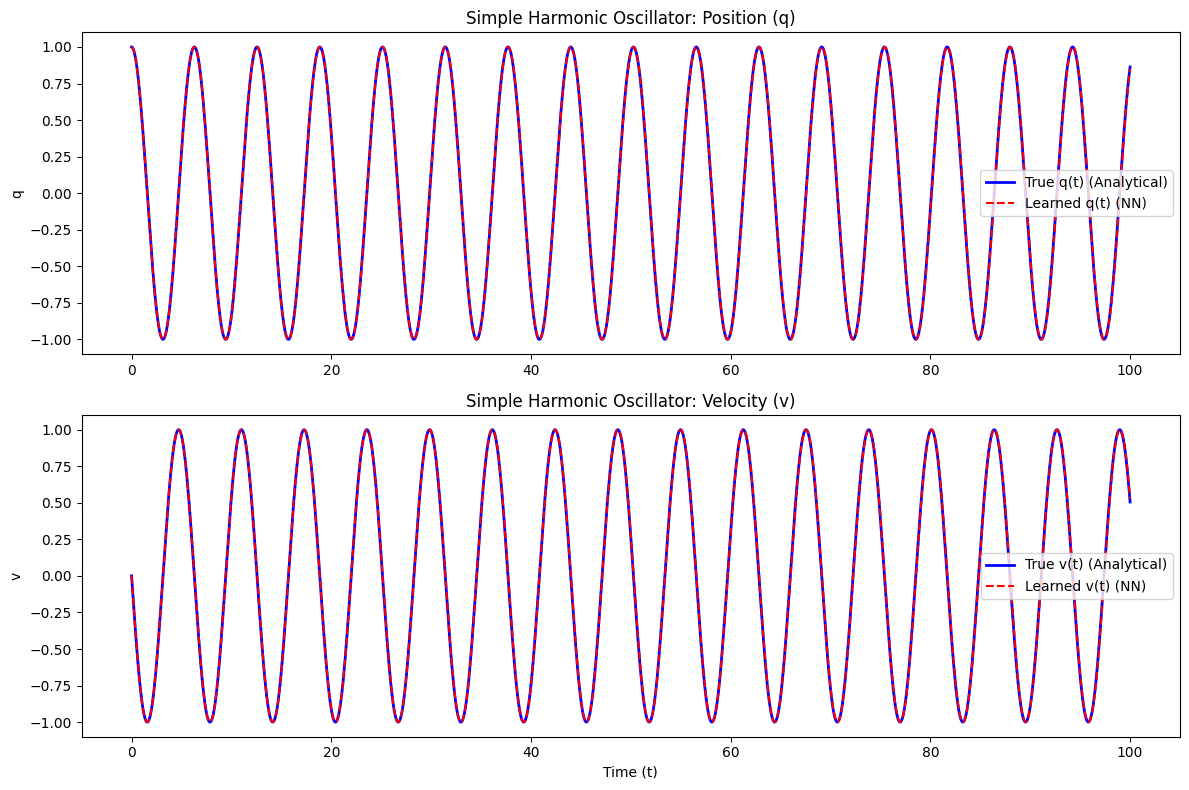

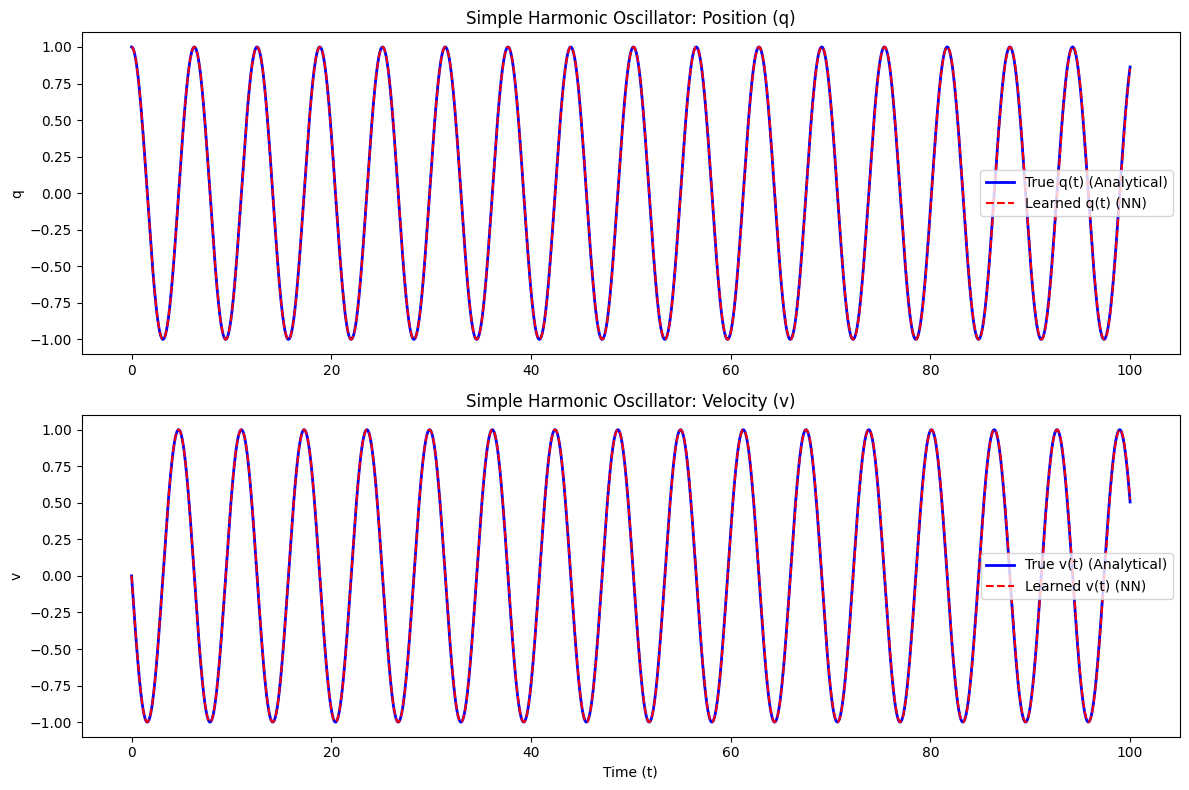

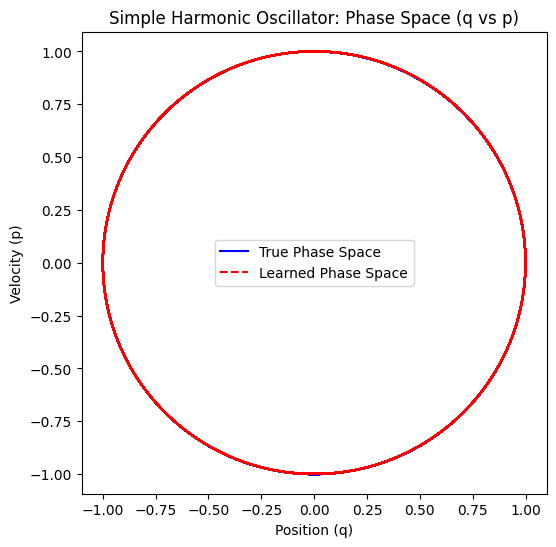

In [192]:
''' 
plot result
'''

#true
t_true_hnn, q_true_hnn, p_true_hnn = ham_states_true
v_true_hnn = lag_states_true[2]

#HNN
t_learned_hnn, q_learned_hnn, p_learned_hnn = ham_states_learned_hnn
v_learned_hnn = lag_states_learned_hnn[2]

#LNN_from_HNN
t_learned_lnn_from_hnn, q_learned_lnn_from_hnn, v_learned_lnn_from_hnn = lag_states_learned_lnn_from_hnn
p_learned_lnn_from_hnn = ham_states_learned_lnn_from_hnn[2]

title_prefix="Simple Harmonic Oscillator:"
plotting.plot_trajectory_comparison(
    t_true_hnn, q_true_hnn, v_true_hnn, 
    t_learned_hnn, q_learned_hnn, v_learned_hnn,
    title_prefix
)

plotting.plot_trajectory_comparison(
    t_true_hnn, q_true_hnn, v_true_hnn, 
    t_learned_lnn_from_hnn, q_learned_lnn_from_hnn, v_learned_lnn_from_hnn,
    title_prefix
)

plotting.plot_phase_space(
    q_true_hnn, p_true_hnn, 
    q_learned_hnn, p_learned_hnn,
    title_prefix
    )

In [193]:
np.savez(
    "results_H1D_HNN.npz", 
    t_true_hnn=np.array(t_true_hnn),
    q_true_hnn=np.array(q_true_hnn),
    v_true_hnn=np.array(v_true_hnn),
    p_true_hnn=np.array(p_true_hnn),
    
    t_learned_hnn=np.array(t_learned_hnn),
    q_learned_hnn=np.array(q_learned_hnn),
    v_learned_hnn=np.array(v_learned_hnn),
    p_learned_hnn=np.array(p_learned_hnn),
    
    t_learned_lnn_from_hnn=np.array(t_learned_lnn_from_hnn),
    q_learned_lnn_from_hnn=np.array(q_learned_lnn_from_hnn),
    v_learned_lnn_from_hnn=np.array(v_learned_lnn_from_hnn),
    p_learned_lnn_from_hnn=np.array(p_learned_lnn_from_hnn),
)